In [2]:
import tensorflow as tf
import numpy as np
import healpy as hp

from DeepSphere import healpy_networks as hp_nn
from DeepSphere import gnn_layers
import matplotlib.pyplot as plt

NSIDE = 32
NPIX = hp.nside2npix(NSIDE)

all_ipix = list(range(NPIX))
hp_map = np.arange(NPIX)

hp_map_nest = hp.reorder(hp_map, r2n=True)
print(np.shape(hp_map_nest))


# define some layers (can be mixed with normal tf layers)
# define only one output layer --> only want the mean !?
layers = [gnn_layers.HealpyPseudoConv(p=1, Fout=4, activation='elu'),
          gnn_layers.HealpyPool(p=1),
          hp_nn.HealpyChebyshev5(K=5, Fout=8),
          gnn_layers.HealpyPseudoConv(p=2, Fout=16, activation='elu'),
          hp_nn.HealpyMonomial(K=5, Fout=32),
          hp_nn.Healpy_ResidualLayer("CHEBY", layer_kwargs={"K": 5}),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(1)]

 # build a model
tf.keras.backend.clear_session()
indices = np.arange(NPIX)
model = hp_nn.HealpyGCNN(nside=NSIDE, indices=indices, layers=layers)

In /Users/BenjaminSuter/opt/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/BenjaminSuter/opt/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/BenjaminSuter/opt/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/BenjaminSuter/opt/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/BenjaminSuter/opt/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_cla

(12288,)
Detected a reduction factor of 16, the input with nside 32 will be reduced to 2 during a forward pass. Checking for consistency with indices...
indices seem consistent...


In [236]:
# we build the model
# unlike most CNN achitectures you MUST supply in the batch dimension here
model.build(input_shape=(1, len(indices), 1))
#model.summary(line_length=100)

inp = np.random.normal(loc=12, size=(1, len(indices), 1)).astype(np.float32)
out = model(inp)


model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), 
              loss='mean_absolute_error')


train_data = []
train_labels = []
for i in range(20000):
    mean = np.random.rand()
    train_labels.append(mean)
    train_data.append(np.random.normal(loc=mean, size=(len(indices), 1)).astype(np.float32))
train_data = np.asarray(train_data)
train_labels = np.asarray(train_labels)


model.fit(train_data, train_labels, epochs=4, validation_split=0.2)

Epoch 1/4
500/500 [==============================] - 9s 19ms/step - loss: 0.5284 - val_loss: 0.2643
Epoch 2/4
500/500 [==============================] - 9s 19ms/step - loss: 0.2650 - val_loss: 0.2493
Epoch 3/4
500/500 [==============================] - 9s 19ms/step - loss: 55.6927 - val_loss: 0.2491
Epoch 4/4
500/500 [==============================] - 9s 19ms/step - loss: 0.2496 - val_loss: 0.2535


In [237]:
for i in range(10):
    mean= np.random.rand()
    predictions = model(np.random.normal(loc=mean, size=(1, len(indices), 1)))
    print("Model predicted %f, true label is %s" % (predictions, mean))

Model predicted 0.438057, true label is 0.6601020288909257
Model predicted 0.438057, true label is 0.41434665118696024
Model predicted 0.438057, true label is 0.2692421258154595
Model predicted 0.438057, true label is 0.38742068944367347
Model predicted 0.438057, true label is 0.26726135986508015
Model predicted 0.438057, true label is 0.8875094255270283
Model predicted 0.438057, true label is 0.5629249756565671
Model predicted 0.438057, true label is 0.42241398245632633
Model predicted 0.438057, true label is 0.06024978594143493
Model predicted 0.438057, true label is 0.5181609379057786


# Now we'll try to implement custom training:

In [3]:
# Redefine the model
#layers = [gnn_layers.HealpyPseudoConv(p=1, Fout=4, activation='elu'),
#          gnn_layers.HealpyPool(p=1),
#          hp_nn.HealpyChebyshev5(K=5, Fout=8),
#          gnn_layers.HealpyPseudoConv(p=2, Fout=16, activation='elu'),
#          hp_nn.HealpyMonomial(K=5, Fout=32),
#          hp_nn.Healpy_ResidualLayer("CHEBY", layer_kwargs={"K": 5}),
#          tf.keras.layers.Flatten(),
#          tf.keras.layers.Dense(1)]

layers = [gnn_layers.HealpyPseudoConv(p=1, Fout=4, activation='elu'),
          gnn_layers.HealpyPseudoConv(p=2, Fout=16, activation='elu'),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(1)]

 # build a model
tf.keras.backend.clear_session()
indices = np.arange(NPIX)
custom_model = hp_nn.HealpyGCNN(nside=NSIDE, indices=indices, layers=layers)

custom_model.build(input_shape=(1, len(indices), 1))

Detected a reduction factor of 8, the input with nside 32 will be reduced to 4 during a forward pass. Checking for consistency with indices...
indices seem consistent...


In [4]:
# Define the loss and gradient function

# Again we will use the MeanAbsoluteError()
loss_object = tf.keras.losses.MeanAbsoluteError()


def loss(model, x, y, training):
    # training=training is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    y_ = model(x, training=training)
    
    return loss_object(y_true=y, y_pred=y_)

# Test the loss function
mean = np.random.rand()
labels = mean
data = np.random.normal(loc=mean, size=(1, len(indices), 1)).astype(np.float32)

l = loss(custom_model, data, labels, training=False)
#print("Loss test: {}".format(l))

In [5]:
# Use the tf.GradientTape contex to calculate the gradients used
# to optimize the model.
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Setup the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Use this to calculate one single optimization step:

loss_value, grads = grad(custom_model, data, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, custom_model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(custom_model, data, labels,
                                               training=True).numpy()))

Step: 0, Initial Loss: 0.8066471219062805
Step: 1,         Loss: 7.012959003448486


In [6]:
# Build a training loop
# We want to generate the data on the fly.

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 100

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    
    # Training loop - use batches of 500
    # Generate the data on the fly
    for i in range(100):
        mean = np.random.rand()
        train_label = mean
        train_data = np.random.normal(loc=mean,
                                      size=(1, len(indices), 1)).astype(np.float32)
        
        # Optimize the model
        loss_value, grads = grad(custom_model, train_data, train_label)
        optimizer.apply_gradients(zip(grads, custom_model.trainable_variables))
        
        # Track progress
        epoch_loss_avg.update_state(loss_value) # Add current batch loss
        # Compare predicted label to actual label
        # training=True is needed only if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        epoch_accuracy.update_state(train_label, custom_model(train_data, training=True))
        
        # End epoch
        train_loss_results.append(epoch_loss_avg.result())
        train_accuracy_results.append(epoch_accuracy.result())
        
    if epoch % 4 == 0:
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

Epoch 000: Loss: 1.028
Epoch 004: Loss: 0.504
Epoch 008: Loss: 0.485
Epoch 012: Loss: 0.988
Epoch 016: Loss: 1.634
Epoch 020: Loss: 1.612
Epoch 024: Loss: 1.197
Epoch 028: Loss: 1.103
Epoch 032: Loss: 1.091
Epoch 036: Loss: 1.103
Epoch 040: Loss: 1.147
Epoch 044: Loss: 1.563
Epoch 048: Loss: 1.230
Epoch 052: Loss: 1.229
Epoch 056: Loss: 1.395
Epoch 060: Loss: 0.998
Epoch 064: Loss: 1.158
Epoch 068: Loss: 1.222
Epoch 072: Loss: 1.383
Epoch 076: Loss: 1.838
Epoch 080: Loss: 1.779
Epoch 084: Loss: 1.683
Epoch 088: Loss: 1.829
Epoch 092: Loss: 1.616
Epoch 096: Loss: 1.110


In [7]:
for i in range(10):
    mean = np.random.rand()
    label = mean
    data = np.random.normal(loc=mean, 
                            size=(1, len(indices), 1)).astype(np.float32)
    predictions = custom_model(data)
    print("Model predicted %f, true label is %s" % (predictions, mean))

Model predicted 1.014382, true label is 0.8603192340059049
Model predicted 0.576817, true label is 0.7542644815211618
Model predicted 1.056386, true label is 0.7049860542318273
Model predicted 1.371791, true label is 0.8380220202775416
Model predicted -0.145998, true label is 0.9344039823882875
Model predicted 3.379085, true label is 0.8120185414704469
Model predicted -0.816014, true label is 0.9224518059113849
Model predicted -2.060829, true label is 0.9179972240894242
Model predicted 1.029763, true label is 0.7237832213144617
Model predicted 0.231367, true label is 0.011695698056331305


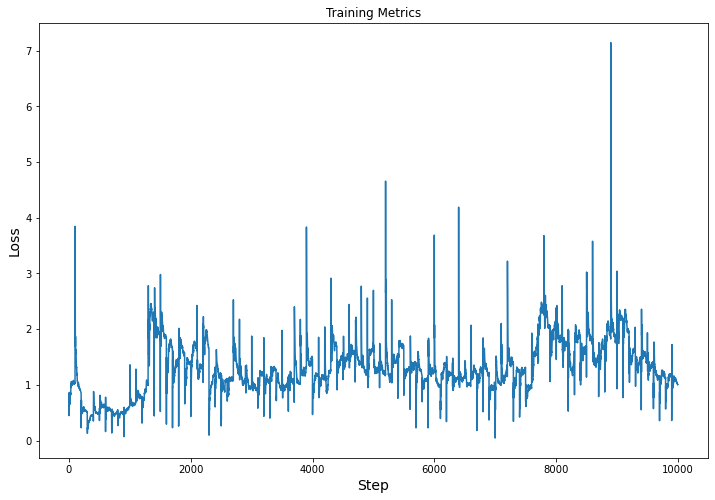

In [8]:
%matplotlib inline
plt.figure(figsize=(12, 8))
plt.title('Training Metrics')

plt.ylabel("Loss", fontsize=14)
plt.plot(train_loss_results)
plt.xlabel("Step", fontsize=14)
plt.show()
